# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

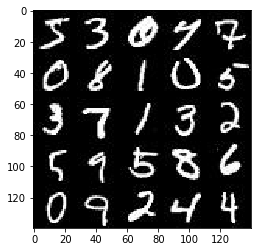

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

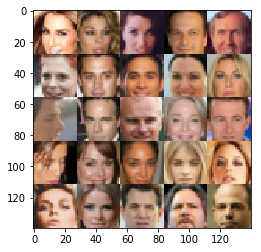

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) #
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) #
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    show_every = 100
    print_every = 2
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = 2 * batch_images
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode) #
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5308... Generator Loss: 0.1239
Epoch 1/2... Discriminator Loss: 0.4784... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.1226... Generator Loss: 3.8530
Epoch 1/2... Discriminator Loss: 0.0655... Generator Loss: 3.3086
Epoch 1/2... Discriminator Loss: 4.6777... Generator Loss: 0.0140
Epoch 1/2... Discriminator Loss: 0.1544... Generator Loss: 6.9689
Epoch 1/2... Discriminator Loss: 0.2369... Generator Loss: 5.1672
Epoch 1/2... Discriminator Loss: 0.3022... Generator Loss: 1.6688
Epoch 1/2... Discriminator Loss: 0.2581... Generator Loss: 4.3970
Epoch 1/2... Discriminator Loss: 0.0272... Generator Loss: 6.3383
Epoch 1/2... Discriminator Loss: 0.0728... Generator Loss: 3.6640
Epoch 1/2... Discriminator Loss: 0.0550... Generator Loss: 5.3334
Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 2.3990
Epoch 1/2... Discriminator Loss: 1.8782... Generator Loss: 0.4592
Epoch 1/2... Discriminator Loss: 2.5508... Generator Loss: 0.3034
Epoch 1/2.

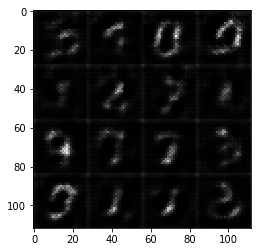

Epoch 1/2... Discriminator Loss: 1.1259... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.8291
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.7239
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 1.6189
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 1.2654... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.4748
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.7475
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.8042
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.1621
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 1.2094
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 1.5713
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 1.6314
Epoch 1/2.

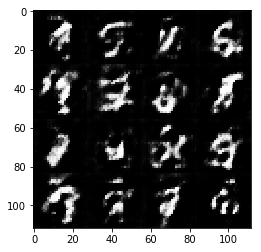

Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 1.3936
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 1.3287
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.5949
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.2199... Generator Loss: 0.5661
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.8489
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 1.1715
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.7642
Epoch 1/2... Discriminator Loss: 1.2501... Generator Loss: 0.4749
Epoch 1/2... Discriminator Loss: 1.6224... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.4957
Epoch 1/2.

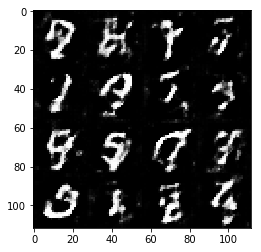

Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.3362... Generator Loss: 0.4670
Epoch 1/2... Discriminator Loss: 1.0316... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.5999
Epoch 1/2... Discriminator Loss: 1.1486... Generator Loss: 0.5013
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.5176
Epoch 1/2... Discriminator Loss: 1.2050... Generator Loss: 0.6196
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.3530... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.6584
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.4949
Epoch 1/2... Discriminator Loss: 1.2207... Generator Loss: 0.4831
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.4719
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.6274
Epoch 1/2.

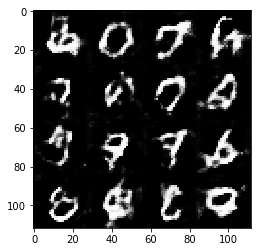

Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.4974
Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 1.0610
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 1.2563... Generator Loss: 1.1213
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 1.3393
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.7144
Epoch 1/2... Discriminator Loss: 1.0608... Generator Loss: 1.1798
Epoch 1/2... Discriminator Loss: 1.2824... Generator Loss: 0.4870
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.0533... Generator Loss: 1.1750
Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 1.0497
Epoch 1/2... Discriminator Loss: 1.5661... Generator Loss: 1.9940
Epoch 1/2.

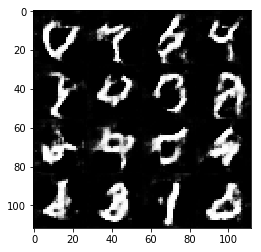

Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.0309
Epoch 2/2... Discriminator Loss: 1.3924... Generator Loss: 0.4642
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.4319
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 1.0682
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.1291... Generator Loss: 0.6049
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.3234
Epoch 2/2... Discriminator Loss: 1.6580... Generator Loss: 0.3568
Epoch 2/2... Discriminator Loss: 1.4668... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.7388
Epoch 2/2.

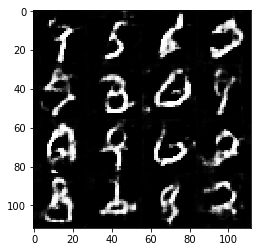

Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.4963
Epoch 2/2... Discriminator Loss: 1.9383... Generator Loss: 0.2540
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.5052
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 0.7403
Epoch 2/2... Discriminator Loss: 1.0490... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 1.2055... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.5263... Generator Loss: 1.0093
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 1.5706
Epoch 2/2... Discriminator Loss: 1.1636... Generator Loss: 1.1260
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 0.8937
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.6605... Generator Loss: 1.5612
Epoch 2/2.

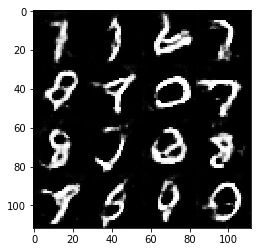

Epoch 2/2... Discriminator Loss: 1.6929... Generator Loss: 0.2839
Epoch 2/2... Discriminator Loss: 1.7566... Generator Loss: 0.2692
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.0738
Epoch 2/2... Discriminator Loss: 1.1789... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.7427
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 1.2675
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 1.0213
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 1.0968... Generator Loss: 0.9754
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 1.1087
Epoch 2/2... Discriminator Loss: 1.2199... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 0.8939
Epoch 2/2.

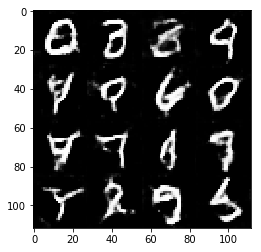

Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.7409
Epoch 2/2... Discriminator Loss: 1.1935... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 1.0513... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.5856
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.5226
Epoch 2/2... Discriminator Loss: 1.1922... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.9840
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 1.5568
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 1.1889
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 1.1928
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.1971... Generator Loss: 1.2357
Epoch 2/2.

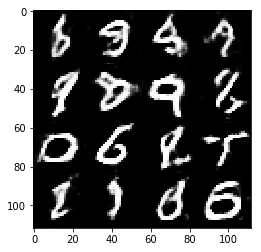

Epoch 2/2... Discriminator Loss: 0.9964... Generator Loss: 1.9291
Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 1.2269
Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.4275... Generator Loss: 0.4545
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 1.1012... Generator Loss: 0.8643
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 1.2815
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 1.0211
Epoch 2/2... Discriminator Loss: 1.1195... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.2213... Generator Loss: 0.6061
Epoch 2/2... Discriminator Loss: 1.1283... Generator Loss: 0.6419
Epoch 2/2... Discriminator Loss: 1.0667... Generator Loss: 0.6397
Epoch 2/2.

In [27]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.2980... Generator Loss: 0.1667
Epoch 1/1... Discriminator Loss: 2.2876... Generator Loss: 0.1679
Epoch 1/1... Discriminator Loss: 2.2360... Generator Loss: 0.1596
Epoch 1/1... Discriminator Loss: 2.0595... Generator Loss: 0.1929
Epoch 1/1... Discriminator Loss: 2.0420... Generator Loss: 0.1914
Epoch 1/1... Discriminator Loss: 2.0387... Generator Loss: 0.2010
Epoch 1/1... Discriminator Loss: 2.0721... Generator Loss: 0.1999
Epoch 1/1... Discriminator Loss: 2.0512... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 2.1002... Generator Loss: 0.2284
Epoch 1/1... Discriminator Loss: 2.0582... Generator Loss: 0.2387
Epoch 1/1... Discriminator Loss: 2.0196... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 2.0730... Generator Loss: 0.2232
Epoch 1/1... Discriminator Loss: 2.0533... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.8639... Generator Loss: 0.3315
Epoch 1/1... Discriminator Loss: 1.7683... Generator Loss: 0.3655
Epoch 1/1.

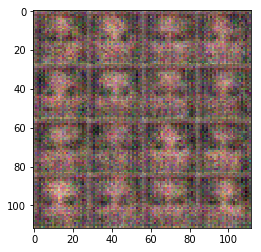

Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.1492
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.7942
Epoch 1/1.

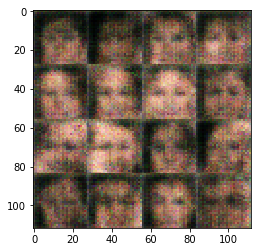

Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7600
Epoch 1/1.

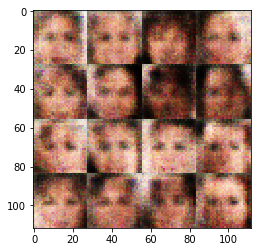

Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.8951
Epoch 1/1... Discriminator Loss: 0.9873... Generator Loss: 1.2030
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.0031
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8597
Epoch 1/1.

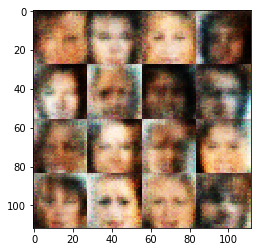

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8613
Epoch 1/1.

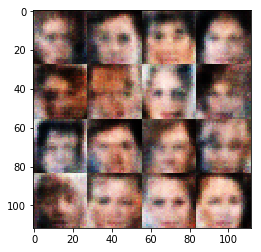

Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8551
Epoch 1/1.

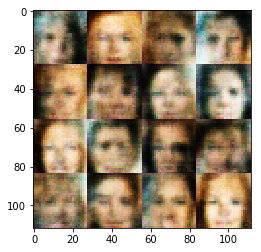

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6677
Epoch 1/1.

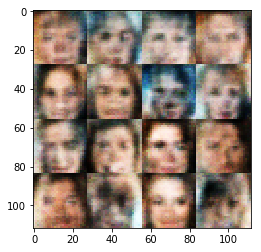

Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.7609
Epoch 1/1.

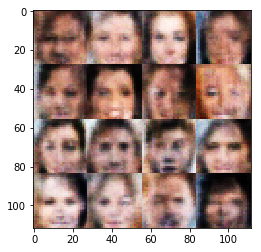

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.9814... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4794
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6872
Epoch 1/1.

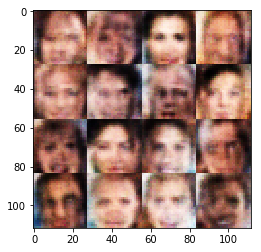

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7368
Epoch 1/1.

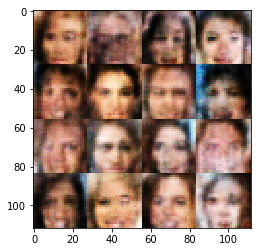

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.0477
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7208
Epoch 1/1.

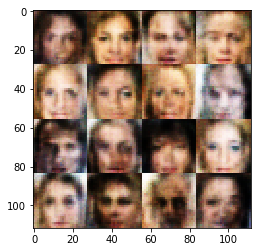

Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.1229
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.1675
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7283
Epoch 1/1.

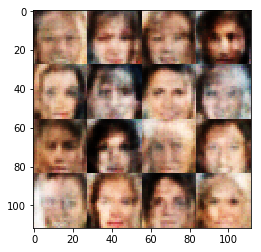

Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.0691
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.6945
Epoch 1/1.

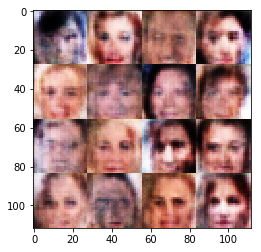

Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1686
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.5511
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.9826
Epoch 1/1.

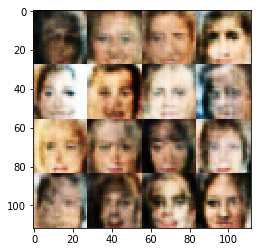

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.0765
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.4662
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6748
Epoch 1/1.

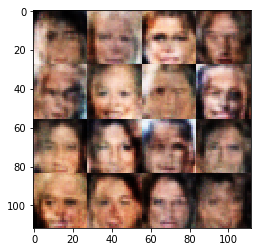

Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.7756
Epoch 1/1.

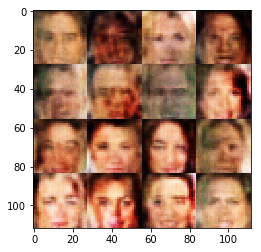

Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7825
Epoch 1/1.

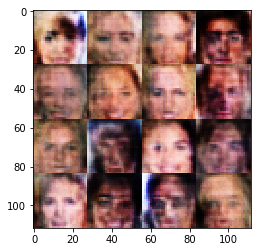

Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7796
Epoch 1/1.

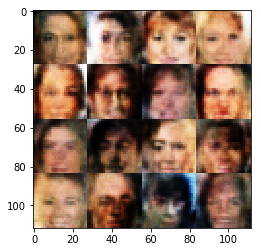

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6832
Epoch 1/1.

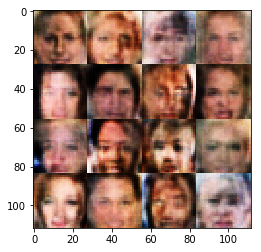

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8165
Epoch 1/1.

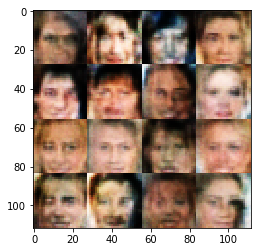

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7092
Epoch 1/1.

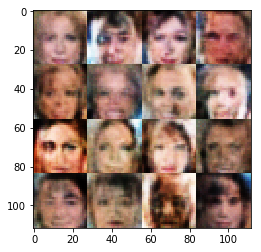

Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7368
Epoch 1/1.

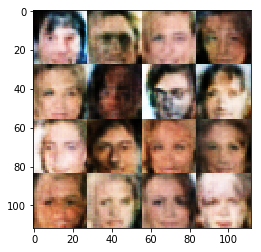

Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7189
Epoch 1/1.

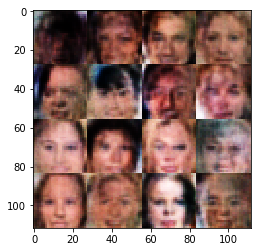

Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.7014... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.6157... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7031
Epoch 1/1.

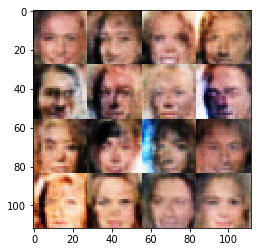

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.9488
Epoch 1/1.

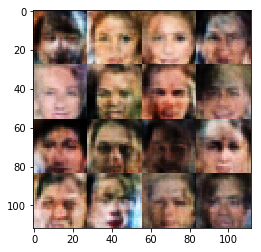

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7758
Epoch 1/1.

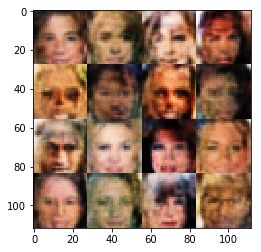

Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7217
Epoch 1/1.

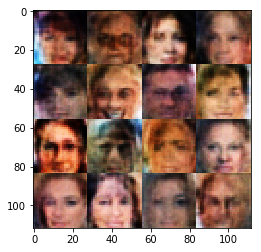

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6937
Epoch 1/1.

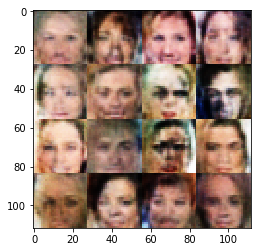

Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 1.1134
Epoch 1/1.

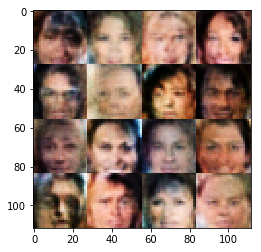

Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.1256
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7609
Epoch 1/1.

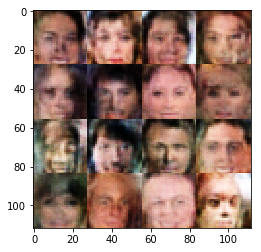

Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.4326
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.7571
Epoch 1/1.

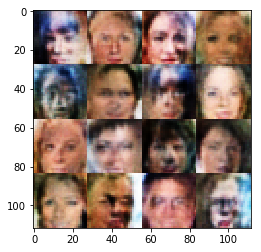

Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7515
Epoch 1/1.

In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.